In [1]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import AxesGrid
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
import numpy as np
import scipy.integrate as sci
import time 
import threading
import sys
import multiprocessing as multiproc
import datetime
# the function library
from projectlib import *
from scipy.optimize import fmin as simplex

## Parameters

In [2]:
class Data:
    def __init__(self, alpha, beta, dimension, name, commuters_day, N):
        "Dimension gives the dimension of the system, i.e. number of cells"
        # ------- TO DO ---------
        # Depending on the system this has to be adjusted
        self.dimension = dimension
        
        "Alpha describes the rate of infection"
        self.alpha = alpha # Dimensions day^(-1)

        "Beta describes the recovery rate"
        self.beta = beta # Dimensions day^(-1)

        "p is the probability to die from the disease"
        self.p = 2.64e-2
        
        """
        Commuters is an array describing the commuters from and to the different cells. 
        The structure is: The entries in column i are how many commute from i to the cell of the row.
                          Thus, the entries of the row i describe how many commute from different cells to cell i.
        """

        self.commuters = np.array([np.ones(self.dimension) for i in range(self.dimension)])
        "load the txt with given name"
        file = np.loadtxt(name, delimiter="\t")
        "fill commuters with the entries from the file. Note the break statement so it doesn't go to far"
        i = 0
        for row in file:
            if i >= self.dimension:
                break
            self.commuters[i] = np.asarray(row[0:self.dimension])
            i += 1
        
        "Part of day that commuters are in other cells. This is the same value for all cells"
        self.commuters_day = commuters_day

        "Array of population in every cell"
        # ------- TO DO ---------
        # figure out how to best do this
        self.N = N

        
        
    def commutersFrom(self, cfrom):
        """Function to extract the commuters from a cell

        Args:
            cfrom (integer): the cell 

         Returns:
            array: array containing commuters from cfrom
        """
        # ------- TO DO ---------
        # optimize the algorithm
        "Sorting out the necessary entries into array a."
        a = np.zeros(self.dimension)
        for i in range(self.dimension):
            a[i] = self.commuters[i][cfrom]
            
        return a 
    
    def commutersTo(self, cto):
        """Function to return an array with number of commuters coming to cto from other cells.

        Args:
            cto (integer): the cell to which the commuters travel

        Returns:
            array: array containing the commuters to cto.
        """
        return self.commuters[cto][:]
       
        
        

## Functions

In [3]:

def function_of_system(timestep, functions,  data, method, t0):
    """Function to calculate the time derivatives of the dynamic SIRD modell with commuters. This function uses multiple approachs for different variant of the system based on prior assumptions. 

        Args:
            functions (array): array with the functions that define the system of equations. Structure [S_1, ... , S_n, I_1, .... , I_n, R_1, ... , R_n, D_1, ... , D_n]
            timestep (float): time of timestep. t=1 is 1 day
            data (class): the class with the relevant data
            method (string): dictates what method is to be used. The choices are "constant", "heaviside"
            t0 (array): array with len = 3 filled with times at which the heaviside functions in the "heaviside" method switch. 
                Note: all values of t0 have to be between 0 and 1.

        Returns:
            array: array containing the derivatives of functions at time t.
    """
    # array with infected
    Infected = functions[data.dimension:2*data.dimension]

    # making array with the effective infected Ieff
    Ieff = np.array([effective_infected(data.commutersTo, data.commutersFrom, data.N, i, Infected, data.dimension) for i in range(data.dimension)])

    # initializing the return array with the time derivatives of functions
    dfuncdt = np.ones(data.dimension*4)

    "~~~~~~~~~~~~~~~~~ See the PDF / LaTeX for further explanation of the equations ~~~~~~~~~~~~~~~~~~~~~~~~"

    # ------------------------------------
    # -      Constant Coefficients       -
    # ------------------------------------

    tt = 0.6

    if method == "constant":
            
        # the for loop to fill dfuncdt

        for i in range(data.dimension):
            # see LaTeX for equations
            # dS/dt
            dfuncdt[i] =  - tt * data.alpha *  functions[i] * functions[i + data.dimension] - (1 - tt) * data.alpha * functions[i] * Ieff[i]

            # dI/dt \propto -dSdt
            dfuncdt[i + data.dimension] = - dfuncdt[i] - data.beta * functions[i + data.dimension]

            # dR/dt
            dfuncdt[i + 2 * data.dimension] = (1 - data.p) * data.beta * functions[i + data.dimension]

            # dD/dt
            dfuncdt[i + 3 * data.dimension] = data.p * data.beta * functions[i + data.dimension]


    # ------------------------------------
    # -      Heaviside Coefficients      -
    # ------------------------------------


    elif method == "heaviside":


        # the for loop to fill dfuncdt
        for i in range(data.dimension):
            # see LaTeX for equations
            # dS/dt
            dfuncdt[i] = - data.alpha * (periodic_heaviside(timestep, t0[0]) + periodic_heaviside(timestep, t0[2]) - 1) * functions[i] * functions[i + data.dimension] - (periodic_heaviside(timestep, t0[1]) - periodic_heaviside(timestep, t0[2])) * data.alpha * functions[i] * Ieff[i]

            # dI/dt \propto -dSdt
            dfuncdt[i + data.dimension] = - dfuncdt[i] - data.beta * functions[i + data.dimension]

            # dR/dt
            dfuncdt[i + 2 * data.dimension] = (1 - data.p) * data.beta * functions[i + data.dimension]

            # dD/dt
            dfuncdt[i + 3 * data.dimension] = data.p * data.beta * functions[i + data.dimension]

    
    
    
    
    
    
    
    # returning the derivatives at time t
    return dfuncdt



# Function for using scipy.integrate.odeint, as the arguments are switched
def system_function(functions, timestep, data, method, t0):
    return function_of_system(timestep, functions, data, method, t0)




In [4]:
p = 0.0264
commuters_day = 10/24

 
dimension = 12
 
a = initial_compartment_distribution(12, "2020/07/24")
initCond = np.zeros(12*4)
for i in range(12):
        initCond[i] = a[i][0]
        initCond[i + 12] = a[i][1]
        initCond[i + 24] = a[i][2]
        initCond[i + 36] = a[i][3]
    
M = region_setup(12)[0]
tzero = np.array([0, 0.4, 0.8])

t = np.linspace(0, 100, 10000)
N = import_rki_data(M, 7)[2]


commuters = np.array([np.ones(dimension) for i in range(dimension)])
"load the txt with given name"
file = np.loadtxt("Pendler.txt", delimiter="\t")
"fill commuters with the entries from the file. Note the break statement so it doesn't go to far"
i = 0
for row in file:
    if i >= dimension:
            break
    commuters[i] = np.asarray(row[0:dimension])
    i += 1

print(N)

[275817.  70458. 136292. 140251. 132285. 326041. 213310. 236764. 202137.
 100629. 100006.  83416.]


## Bausteine für Optimierungsverfahren

#### RKI Vergleichsdaten

In [213]:
###find first day of simulation and import RKI_Inzidenzwert
RKI= np.load("Internal Data/rki_region_cases38.npy") 
begin_of_recording = datetime.datetime.strptime("2020/03/01","%Y/%m/%d")
begin_of_simulation = datetime.datetime.strptime("2020/07/24", "%Y/%m/%d")
d0=(begin_of_simulation-begin_of_recording).days
# Inzidenzwert im k-ten Landkreis am d-ten Tag ist RKI[k][2][d0-1+d] 

M_ =  region_setup(38)[0]
N_ = import_rki_data(M_, 7)[2]
#N_ enthält Anzahl der Bevölkerung der Landkreis
RKI_data = np.load("Internal Data/timeline.npy")
I_RKI = np.array([RKI_data[i][1] for i in range(38)])
#I_RKI[Landkreis][Tag]

#### Simulationsdaten

In [197]:
def find_sol_on_days_(solt, soly, lk_indzies, number_of_days, number_of_Lks, results_type = 0):
    # returns X[Landkreis][Tag]  S for results_type = 0, I for results_type = 1, R for results_type=2
    # and D for results_type=3
    start_punkt = results_type * number_of_Lks
    if not lk_indzies: 
        # if list is empty, simulation is calculated for all regions 
        S=np.empty((number_of_Lks,number_of_days+1), dtype=float, order='C')
        for l in range(number_of_Lks):
            k = l + start_punkt
            i=0
            goodtime=0
            for time in range(len(solt)):
                if abs(solt[time]-i)<1e-2:
                    goodtime=time
                    if time+1 <len(solt):
                        if abs(solt[time+1]-i)<abs(solt[time]-i):
                            goodtime=time+1
                    S[l][i]=soly[k][goodtime]
                    i=i+1
    else: # simulation is calculaten for specified regions
        number_of_Lks = len(lk_indzies)
        S = np.empty((number_of_Lks,number_of_days+1), dtype=float, order='C')
        for l in range(number_of_Lks):
            k = lk_indzies[l]
            k = k +start_punkt
            i=0
            goodtime=0
            for time in range(len(solt)):
                if abs(solt[time]-i)<1e-2:
                    goodtime=time
                    if time+1 <len(solt):
                        if abs(solt[time+1]-i)<abs(solt[time]-i):
                            goodtime=time+1
                    S[l][i]=soly[k][goodtime]
                    i=i+1
    return S ## returns X[Landkreis][Tag]


def summon_results(params, method, lk_indzies = [], number_of_days=100, number_of_Lks=12, results_type = 0):
    # returns S[Landkreis][Tag] for results_type = 0, I for results_type = 1, R for results_type=2
    # and D for results_type=3
    # lk_indzies can be out of order or empty for all regions. 
    dimension = number_of_Lks
    alpha = params[0]
    beta = params[1]
    simulation001 = Data(alpha, beta, dimension, "Pendler.txt", 0.6, import_rki_data(M, 7)[2])
    sol = sci.solve_ivp(fun=function_of_system, t_span=(0, 100), y0=initCond, method="RK45", args=(simulation001, method, tzero), t_eval=t, dense_output=True)
    solt=sol.t
    soly=sol.y
    ss = find_sol_on_days_(solt, soly, lk_indzies, number_of_days, number_of_Lks, results_type)
    return ss

# Usage examples
#print(summon_results([.4,1/14], 'constant',[11,3])) 
#print(len(summon_results([.4,1/14], 'constant')))

#### Tests zur Simulation

Warum ist R größer als I im gleichen Landkreis?

In [273]:
parameter_ = [0.14,0.08]
method = 'constant'
Simu_S = summon_results(parameter_, method, lk_indzies = [1,11,5], number_of_days=100, number_of_Lks=12, results_type =0)
Simu_I = summon_results(parameter_, method, lk_indzies = [3,11,2], number_of_days=100, number_of_Lks=12, results_type = 1)
Simu_R = summon_results(parameter_, method, lk_indzies = [10,11,9], number_of_days=100, number_of_Lks=12, results_type = 2)
Simu_D = summon_results(parameter_, method, lk_indzies = [7,11,1,4], number_of_days=100, number_of_Lks=12, results_type = 3)


(3, 101)


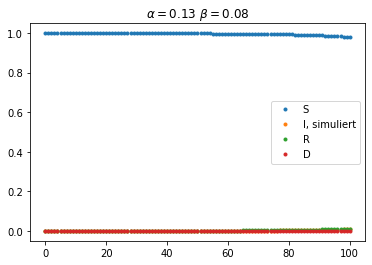

In [274]:
t = np.array([i for i in range(len(Simu_S[1]))])
plt.plot(t,Simu_S[1], '.', label="S")
plt.plot(t,Simu_I[1], '.', label="I, simuliert")
plt.plot(t,Simu_R[1], '.', label="R")
plt.plot(t,Simu_D[1], '.', label="D")
#plt.plot(t,Simu_S[0], '.', label="Lk=1")
#plt.plot(t,Simu_S[2], '.', label="Lk=5")
#plt.plot(t,Simu_S[1], '.', label="Lk=11")
plt.legend()
plt.title("$\\alpha= 0.13$ $ \\beta= 0.08$")
print(Simu_S.shape)

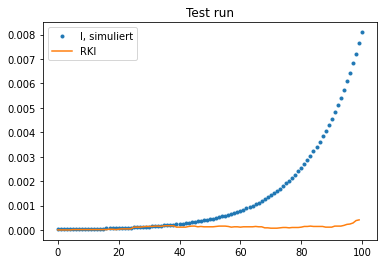

In [275]:
plt.plot(t,Simu_I[1], '.', label="I, simuliert")
plt.plot(t[:100],I_RKI[1], label = 'RKI')
plt.title("Test run")
plt.legend()

#### Berechnung des Inzidenzwerts 

In [74]:
def Inzidenzwert(d,k,is_sim, S):
    # d ist Tag k ist Landkreis
    # die Funktion berechnet Inzidenzwert der Simulation an Tag d in Landkreis k
    if is_sim == 0:
        Oomega = RKI[k][2][d0-1+d]
        return Oomega
    else:
        if d<7:
            Omega = -(S[k][d]-S[k][0])
        if d==0:
            Omega = S[k][0]
        else:
            Omega = -(S[k][d]-S[k][d-7])
            
    return Omega*100000

def find_index(k, lk_indzies = []):
    if not lk_indzies:
        return k
    else:
        return lk_indzies[k]
    
def Omega_ges(N_, d, is_sim, number_of_Lks=12, lk_indzies = [], S = []):
    numberofLks = len(lk_indzies)
    if numberofLks == 0:
            numberofLks = number_of_Lks
    res = 0
    N_tot = 0
    for i in range(numberofLks):
        k = find_index(i, lk_indzies)
        res = res + N_[k]*Inzidenzwert(d,k,is_sim, S)/100000
        N_tot = N_tot + N_[k]
    return res/N_tot
         
Simu = summon_results([0.165,1/14], 'constant',[])
print("Inzidenzwerte im 1-ten Landkreis am Tag 12:")
print("Simulation:", round(Inzidenzwert(12,1,1, Simu),2))
print("RKI:", round(Inzidenzwert(12,1,0, Simu),2))

Inzidenzwerte im 1-ten Landkreis am Tag 12:
Simulation: 1.49
RKI: 1.42


## Bewertungsfunktionen

functions must take the following arguments:

    params, method ='constant', lk_indzies = [], number_of_days = 100, number_of_Lks = 12
    
some version of the following code is required:

    if (params[0]<0):
        return np.inf
    if (params[1]<0):
        return np.inf
    x = summon_results(params, method, lk_indzies, number_of_days, number_of_Lks,results_type)
x ist ein Array der Form x[Landkreis][Tag]    
Wähle results_type = 0 für S, results_type = 1 für I, results_type=2 für R
und results_type=3 für D

In [235]:
def f_0(params, method ='constant', lk_indzies = [], number_of_days = 100, number_of_Lks = 12):
    if (params[0]<0):
        return np.inf
    if (params[1]<0):
        return np.inf
    S = summon_results(params, method, lk_indzies, number_of_days, number_of_Lks)
    #S[Landkreis][Tag]
    res = 0
    for d in range(len(S[0])):
        Omega_rki = Omega_ges(N_, d, 0, number_of_Lks, lk_indzies)
        res = res + ((Omega_ges(N_, d, 1, number_of_Lks, lk_indzies, S) - Omega_rki )/Omega_rki)**2
    return res


def f_1(params, method ='constant', lk_indzies = [], number_of_days = 100, number_of_Lks = 12):
    if (params[0]<0):
        return np.inf
    if (params[1]<0):
        return np.inf
    S = summon_results(params, method, lk_indzies, number_of_days, number_of_Lks)
    res = 0
    for d in range(len(S[0])):
        Omega_rki = Omega_ges(N_, d, 0, number_of_Lks, lk_indzies)
        res = res + ((Omega_ges(N_, d, 1, number_of_Lks, lk_indzies, S) - Omega_rki )**2/Omega_rki)
    return res


def f_2(params, method ='constant', lk_indzies = [], number_of_days = 100, number_of_Lks = 12):
    if (params[0]<0):
        return np.inf
    if (params[1]<0):
        return np.inf
    S = summon_results(params, method, lk_indzies, number_of_days, number_of_Lks)
    numberofLks = len(lk_indzies)
    if numberofLks == 0:
            numberofLks = number_of_Lks
    res = 0
    for d in range(len(S[0])):
        for i in range(numberofLks):
            k = find_index(i, lk_indzies)
            res = res + ((Inzidenzwert(d,k,0, S)-Inzidenzwert(d,k,1, S))/(Inzidenzwert(d,k,1, S)))**2
    return res


def f_3(params, method ='constant', lk_indzies = [], number_of_days = 100, number_of_Lks = 12):
    if (params[0]<0):
        return np.inf
    if (params[1]<0):
        return np.inf
    S = summon_results(params, method, lk_indzies, number_of_days, number_of_Lks)
    numberofLks = len(lk_indzies)
    if numberofLks == 0:
            numberofLks = number_of_Lks
    res = 0
    r = []
    for d in range(len(S[0])):
        for i in range(numberofLks):
            k = find_index(i, lk_indzies)
            
            r.append(((Inzidenzwert(d,k,0, S)-Inzidenzwert(d,k,1, S))/(Inzidenzwert(d,k,1, S)))**2)
    res = sum(r) + 5 * sum([abs(r[k]-sum(r)/len(r)) for k in range(len(r))])
    return res

def f_4(params, method ='constant', lk_indzies = [], number_of_days = 100, number_of_Lks = 12):
    if (params[0]<0):
        return np.inf
    if (params[1]<0):
        return np.inf
    S = summon_results(params, method, lk_indzies, number_of_days, number_of_Lks)
    numberofLks = len(lk_indzies)
    if numberofLks == 0:
            numberofLks = number_of_Lks
    res = 0
    r = 0
    N_tot = 0
    for d in range(len(S[0])):
        for i in range(numberofLks):
            k = find_index(i, lk_indzies)
            omega_d_k_RKI = Inzidenzwert(d,k,0, S)
            if omega_d_k_RKI == 0:
                r = N_[k]*Inzidenzwert(d,k,1, S)
            else:
                r = N_[k]*((omega_d_k_RKI -Inzidenzwert(d,k,1, S))/(omega_d_k_RKI))**2
            N_tot = N_tot + N_[k]
            res = res + r
    return res/N_tot

def f_5(params, method ='constant', lk_indzies = [], number_of_days = 100, number_of_Lks = 12):
    if (params[0]<0):
        return np.inf
    if (params[1]<0):
        return np.inf
    I = summon_results(params, method, lk_indzies, number_of_days, number_of_Lks, results_type = 1)
    numberofLks = len(lk_indzies)
    if numberofLks == 0:
            numberofLks = number_of_Lks
    res = 0
    for d in range(number_of_days):
        for i in range(numberofLks):
            k = find_index(i, lk_indzies)
            r = I_RKI[k][d]
            if r == 0:
                i = i+1
            else:
                res = res + ((I[i][d]-r)/r)**2
    return res

In [237]:
print(f_0([.4,1/14], 'heaviside'))
print(f_1([.4,1/14], 'heaviside'))
print(f_2([.4,1/14], 'heaviside'))
print(f_3([.4,1/14], 'heaviside'))
print(f_4([.4,1/14], 'heaviside'))
print(f_5([.4,1/14], 'heaviside'))

27217703938.864086
431167.57803114003
344376.444100218
3766368.679072789
347880340.6492753
18721016879.845387


In [269]:
print(f_5([.3,1/14], 'constant'))
print(f_5([.5,1/14], 'constant'))
print(f_5([.1,1/14], 'constant'))
print(f_5([.7,1/14], 'constant'))

28127338314.461845
51655036245.81279
2528.662263794314
42950861640.51848


### In-house optimizer

In [150]:
def Bew(params, function, component_value = 0, which_component =-1,\
        method = 'constant', lk_indzies = [], number_of_days = 100, number_of_Lks = 12 ): 
    ## function specifies which Bewertungsfunktion to use
    if which_component == -1:
        return function(params, method, lk_indzies, number_of_days, number_of_Lks)
    else:
        z = params
        z[which_component] = component_value
        return function(z, method, lk_indzies, number_of_days, number_of_Lks)

    
def isbetter(new_eval, current_eval):
    if new_eval > current_eval:
        return 1
    else:
        return 0
    
def improve(params, function, which_component, component_value, sign, evals,\
            method = 'constant', lk_indzies = [], number_of_days = 100, number_of_Lks = 12):
    i = 0
    d = 0
    last_sucess = 0
    new_eval = evals
    value = component_value
    o_err=2
    if (which_component == -1):
        while i - last_sucess < 15 and o_err < 4:
            if i - last_sucess >8:
                o_err = o_err + 1
                last_sucess = 0
                i = 0
                component = value
            d = i * 10**(-o_err) * sign * np.array(value)
            component_value = value + d
            evals=new_eval
            new_eval = Bew(params, function, component_value, which_component,\
        method, lk_indzies, number_of_days, number_of_Lks)
            i = i + 1
        if new_eval < evals:
            last_sucess=last_sucess + 1
            value = component_value
            #print(new_eval," ", params)
    i = 0
    d = 0
    last_sucess = 0
    while i - last_sucess < 15 and o_err < 4:
        if i - last_sucess >8:
            o_err = o_err + 1
            last_sucess = 0
            i = 0
            component_value = value
        d = i * 10**(-o_err) * sign
        component_value = value + d
        evals = new_eval
        new_eval = Bew(params, function, component_value, which_component,\
        method, lk_indzies, number_of_days, number_of_Lks )
        i = i + 1
        if new_eval < evals:
            last_sucess=last_sucess + 1
            value = component_value
            #print(new_eval," ", params)
    return value, new_eval
  
   

In [151]:
def improve_component(params, function, which_component, \
            method = 'constant', lk_indzies = [], number_of_days = 100, number_of_Lks = 12):
    
    if which_component == -1:
        component_value = params
    else:
        component_value = params[which_component]
    start_eval = Bew(params, function, component_value, which_component)
    component_pos, eval1 = improve(params, function, which_component, component_value, 1, start_eval,\
                                  method, lk_indzies, number_of_days, number_of_Lks)
    component_neg, eval2 = improve(params, function, which_component, component_value, -1, start_eval,\
                                  method, lk_indzies, number_of_days, number_of_Lks)
    if eval1<eval2:
        return component_pos
    else:
        return component_neg


In [152]:
def optimize(parameters, function, \
            method = 'constant', lk_indzies = [], number_of_days = 100, number_of_Lks = 12):
    
    improved_paramters=np.array(parameters)
    for e in range(len(parameters)):
        improved_paramters[e] = improve_component(parameters, function, e,\
                                                  method, lk_indzies, number_of_days, number_of_Lks)
    return improve_component(parameters, function, -1,\
                             method, lk_indzies, number_of_days, number_of_Lks)



# Test Optimization

## Simplex

to use copy any of the following cells.   
**args**  can be used as follows:
- **methode** can be either 'constant' or 'heaviside', has default value of 'constant'
- **lk_indzies** is list of specific regions. it can be out of order. leave empty for all regions
- **number_of_Lks** can either be 12 or 36, has default value of 12
- **number_of_days** has default value of 100

In [202]:
simplex(f_3,[.4,1/14], args=('heaviside',), xtol=0.0001, ftol=0.0001, maxiter=None, maxfun=None, full_output=0, disp=1, retall=0, callback=None, initial_simplex=None )

# output:
# [0.42678053, 0.07426423]

Optimization terminated successfully.
         Current function value: 1477.115906
         Iterations: 53
         Function evaluations: 119


array([0.42678053, 0.07426423])

In [114]:
simplex(f_2,[.4,1/14], args=('heaviside',), xtol=0.0001, ftol=0.0001, maxiter=None, maxfun=None, full_output=0, disp=1, retall=0, callback=None, initial_simplex=None )

# output:
# [0.4669364 , 0.08100945]

In [115]:
simplex(f_1,[.4,1/14], args=('heaviside',), xtol=0.0001, ftol=0.0001, maxiter=None, maxfun=None, full_output=0, disp=1, retall=0, callback=None, initial_simplex=None )

# output: 
# [0.36965686, 0.07743744]

Optimization terminated successfully.
         Current function value: 330918.376905
         Iterations: 128
         Function evaluations: 269


array([0.36965686, 0.07743744])

In [116]:
simplex(f_0,[.4,1/14], args=('heaviside',), xtol=0.0001, ftol=0.0001, maxiter=None, maxfun=None, full_output=0, disp=1, retall=0, callback=None, initial_simplex=None )

# output: 
# [0.37103014, 0.0782182 ]

array([0.37103014, 0.0782182 ])

In [178]:
simplex(f_4,[.4,1/14], args=('heaviside',), xtol=0.0001, ftol=0.0001, maxiter=None, maxfun=None, full_output=0, disp=1, retall=0, callback=None, initial_simplex=None )

#output: 
# [0.4669364 , 0.08100945]

Optimization terminated successfully.
         Current function value: 268853003.037759
         Iterations: 158
         Function evaluations: 330


array([0.37726444, 0.07770997])

In [238]:
simplex(f_5,[.4,1/14], args=('heaviside',), xtol=0.0001, ftol=0.0001, maxiter=None, maxfun=None, full_output=0, disp=1, retall=0, callback=None, initial_simplex=None )

#output:
# [0.12000558, 0.10357076]

Optimization terminated successfully.
         Current function value: 693.757678
         Iterations: 54
         Function evaluations: 118


array([0.12000558, 0.10357076])

## In-house

**currently is not working correctly!**

to run simply use:

    optimize(parameters, function, method = 'constant', lk_indzies = [], number_of_days = 100, number_of_Lks = 12)

Arguments after function are optional:

- **methode** can be either 'constant' or 'heaviside', has default value of 'constant'
- **lk_indzies** is list of specific regions. it can be out of order. leave empty for all regions
- **number_of_Lks** can either be 12 or 36, has default value of 12
- **number_of_days** has default value of 100

In [179]:
functions = [f_0, f_1, f_2, f_3, f_4]
function_names = ["f_0", "f_1", "f_2", "f_3", "f_4"]
res = [optimize([.4,1/14],functions[i], 'constant') for i in range(len(functions))]
for i in range(len(functions)):
    print("used function: ", function_names[i])
    print("Current function value: ", functions[i](res[i], 'constant'))
    print ("optimale Parameter: ", res[i])


used function:  f_0
Current function value:  4503255600.417591
optimale Parameter:  [0.00399999999999999, 0.07142857142857142]
used function:  f_1
Current function value:  66966.04272081747
optimale Parameter:  [0.00399999999999999, 0.05142857142857142]
used function:  f_2
Current function value:  13321447.57504609
optimale Parameter:  [0.01999999999999999, 0.0014285714285714258]
used function:  f_3
Current function value:  128943603.67139372
optimale Parameter:  [0.01999999999999999, 0.0014285714285714258]
used function:  f_4
Current function value:  45837836.13322977
optimale Parameter:  [0.00399999999999999, 0.07142857142857142]


## Plots

In [177]:
functions = [f_0, f_1, f_2, f_3, f_4]

In [180]:
resolution = 10

alpha = np.linspace(0,1,resolution)
beta = np.linspace(0,1,resolution)
Z_const = np.array([np.zeros((resolution, resolution)) for f in range(len(functions))])
Z_heavi = np.array([np.zeros((resolution, resolution)) for f in range(len(functions))])

for f in range(len(functions)):
    for i in range(len(alpha)):
        for j in range(len(beta)):
            Z_const[f][i][j] = functions[f]([alpha[i],beta[j]], method='constant')
            Z_heavi[f][i][j] = functions[f]([alpha[i],beta[j]], method='heaviside')
        

/tmp/ipykernel_59463/2094289639.py:41: RuntimeWarning: divide by zero encountered in double_scalars
  res = res + ((Inzidenzwert(d,k,0, S)-Inzidenzwert(d,k,1, S))/(Inzidenzwert(d,k,1, S)))**2
/tmp/ipykernel_59463/2094289639.py:41: RuntimeWarning: invalid value encountered in double_scalars
  res = res + ((Inzidenzwert(d,k,0, S)-Inzidenzwert(d,k,1, S))/(Inzidenzwert(d,k,1, S)))**2
/tmp/ipykernel_59463/2094289639.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  r.append(((Inzidenzwert(d,k,0, S)-Inzidenzwert(d,k,1, S))/(Inzidenzwert(d,k,1, S)))**2)
/tmp/ipykernel_59463/2094289639.py:60: RuntimeWarning: invalid value encountered in double_scalars
  r.append(((Inzidenzwert(d,k,0, S)-Inzidenzwert(d,k,1, S))/(Inzidenzwert(d,k,1, S)))**2)


In [239]:
resolution = 10

alpha = np.linspace(0,1,resolution)
beta = np.linspace(0,1,resolution)
Z_const_5 = np.zeros((resolution, resolution))
Z_heavi_5 = np.zeros((resolution, resolution))

for f in range(len(functions)):
    for i in range(len(alpha)):
        for j in range(len(beta)):
            Z_const_5[i][j] = f_5([alpha[i],beta[j]], method='constant')
            Z_heavi_5[i][j] = f_5([alpha[i],beta[j]], method='heaviside')
        

In [242]:
Z_const_5

array([[1.14499582e+15, 1.14499582e+15, 1.14499582e+15, 1.14499582e+15,
        1.14499582e+15, 1.14499582e+15, 1.14499582e+15, 1.14499582e+15,
        1.14499582e+15, 1.14499582e+15],
       [1.14499582e+15, 1.14499582e+15, 1.14499582e+15, 1.14499582e+15,
        1.14499582e+15, 1.14499582e+15, 1.14499582e+15, 1.14499582e+15,
        1.14499582e+15, 1.14499582e+15],
       [1.14499582e+15, 1.14499582e+15, 1.14499582e+15, 1.14499582e+15,
        1.14499582e+15, 1.14499582e+15, 1.14499582e+15, 1.14499582e+15,
        1.14499582e+15, 1.14499582e+15],
       [1.14499582e+15, 1.14499582e+15, 1.14499582e+15, 1.14499582e+15,
        1.14499582e+15, 1.14499582e+15, 1.14499582e+15, 1.14499582e+15,
        1.14499582e+15, 1.14499582e+15],
       [1.14499582e+15, 1.14499582e+15, 1.14499582e+15, 1.14499582e+15,
        1.14499582e+15, 1.14499582e+15, 1.14499582e+15, 1.14499582e+15,
        1.14499582e+15, 1.14499582e+15],
       [1.14499582e+15, 1.14499582e+15, 1.14499582e+15, 1.14499582e+15,
   

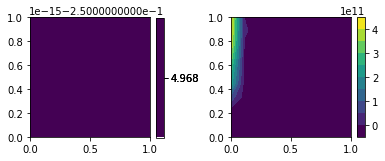

In [240]:
#### Funktion f_4
#ändere die 4 in Z_const[4] um andere Funktionen zu plotten

Zdiff_const = Z_const_5 - np.mean(Z_const_5)
Zdiff_heavi = Z_heavi_5 - np.mean(Z_heavi_5)

# norm = cm.colors.Normalize(vmax=max(Zdiff_const.max(), Zdiff_heavi.max()), vmin=min(Zdiff_const.min(), Zdiff_heavi.min()))
norm_const = cm.colors.Normalize(vmax=Zdiff_const.max(), vmin=Zdiff_const.min())
norm_heavi = cm.colors.Normalize(vmax=Zdiff_heavi.max(), vmin=Zdiff_heavi.min())
ALPHA, BETA = np.meshgrid(alpha, beta)

# if one colorbar (i.e. corresponding colours) for both plots is wanted:
'''
fig = plt.figure()

grid = AxesGrid(fig, 111,
                nrows_ncols=(1, 2),
                axes_pad=0.25,
               cbar_mode='single',
                cbar_location='right',
                cbar_pad=0.1
                )

cset = grid[0].contourf(
    ALPHA, BETA, Zdiff_const, resolution, norm=norm
    )

cset = grid[1].contourf(
    ALPHA, BETA, Zdiff_heavi, resolution, norm=norm
    )

for ax in grid:
    ax.set_xlim(0, 1)

cbar = ax.cax.colorbar(cset)
cbar = grid.cbar_axes[0].colorbar(cset)
'''

fig, (ax1, ax2) = plt.subplots(1,2)
fig.subplots_adjust(wspace=0.5)

cset1 = ax1.contourf(
    ALPHA, BETA, Zdiff_const, resolution, vmax=Zdiff_const.max(), vmin=Zdiff_const.min()
)
ax1.set(adjustable='box', aspect='equal')
ax1_divider = make_axes_locatable(ax1)
cax1 = ax1_divider.append_axes("right", size="7%", pad="5%")
cbar1 = fig.colorbar(cset1, cax=cax1)

cset2 = ax2.contourf(
    ALPHA, BETA, Zdiff_heavi, resolution, vmax=Zdiff_heavi.max(), vmin=Zdiff_heavi.min()
)
ax2.set(adjustable='box', aspect='equal')
ax2_divider = make_axes_locatable(ax2)
cax2 = ax2_divider.append_axes("right", size="7%", pad="5%")
cbar2 = fig.colorbar(cset2, cax=cax2)

#ax.set_yscale('log')
#ax.set_xscale('log')
#ax.set_ylim(0, 1)
#ax.set_xticks([])
#ax.set_yticks([])

#Zdiff_const

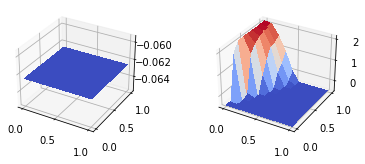

In [205]:
fig, (ax1, ax2) = plt.subplots(1,2, subplot_kw={"projection": "3d"})
fig.subplots_adjust(wspace=0.5)
surf1 = ax1.plot_surface(ALPHA, BETA, Zdiff_const, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
surf2 = ax2.plot_surface(ALPHA, BETA, Zdiff_heavi, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)


## Fehler der Parameter

**Vorsicht!**
Die nächste Zelle dauert seher **lange!**

In [182]:
function = f_4 ## welche Bewertungsfunktion verwendet werden soll
sample_size = 10
alpha_ = np.linspace(0,1,sample_size)
beta_ = np.linspace(0,1,sample_size)
optimal_params_const = []
optimal_params_heavi = []

for i in range(len(alpha)):
        for j in range(len(beta)):
            optimal_params_const.append(simplex(function,[.4,1/14],\
                    args=('const',), xtol=0.0001, ftol=0.0001,\
                    maxiter=None, maxfun=None, full_output=0, disp=1,\
                    retall=0, callback=None, initial_simplex=None ))
            optimal_params_heavi.append(simplex(function,[.4,1/14],\
                    args=('heaviside',), xtol=0.0001, ftol=0.0001,\
                    maxiter=None, maxfun=None, full_output=0, disp=1,\
                    retall=0, callback=None, initial_simplex=None ))
            


Optimization terminated successfully.
         Current function value: 2880201418364.551758
         Iterations: 9
         Function evaluations: 35
Optimization terminated successfully.
         Current function value: 268853003.037759
         Iterations: 158
         Function evaluations: 330
Optimization terminated successfully.
         Current function value: 2880201418364.551758
         Iterations: 9
         Function evaluations: 35
Optimization terminated successfully.
         Current function value: 268853003.037759
         Iterations: 158
         Function evaluations: 330
Optimization terminated successfully.
         Current function value: 2880201418364.551758
         Iterations: 9
         Function evaluations: 35
Optimization terminated successfully.
         Current function value: 268853003.037759
         Iterations: 158
         Function evaluations: 330
Optimization terminated successfully.
         Current function value: 2880201418364.551758
         Iteratio

Optimization terminated successfully.
         Current function value: 2880201418364.551758
         Iterations: 9
         Function evaluations: 35
Optimization terminated successfully.
         Current function value: 268853003.037759
         Iterations: 158
         Function evaluations: 330
Optimization terminated successfully.
         Current function value: 2880201418364.551758
         Iterations: 9
         Function evaluations: 35
Optimization terminated successfully.
         Current function value: 268853003.037759
         Iterations: 158
         Function evaluations: 330
Optimization terminated successfully.
         Current function value: 2880201418364.551758
         Iterations: 9
         Function evaluations: 35
Optimization terminated successfully.
         Current function value: 268853003.037759
         Iterations: 158
         Function evaluations: 330
Optimization terminated successfully.
         Current function value: 2880201418364.551758
         Iteratio

KeyboardInterrupt: 

In [183]:
alpha_mean_const = sum([optimal_params_const[i][0]\
                        for i in range(len(optimal_params_const))])/len(optimal_params_const)
alpha_mean_heavi = sum([optimal_params_heavi[i][0]\
                        for i in range(len(optimal_params_heavi))])/len(optimal_params_heavi)
alpha_stdev_const = np.std(np.array([optimal_params_heavi[i][1]\
                                       for i in range(len(optimal_params_heavi))]))  
alpha_stdev_heavi = np.std(np.array([optimal_params_heavi[i][1]\
                                       for i in range(len(optimal_params_heavi))]))  


beta_mean_const = sum([optimal_params_const[i][1]\
                        for i in range(len(optimal_params_const))])/len(optimal_params_const)

beta_mean_heavi = sum([optimal_params_heavi[i][1]\
                        for i in range(len(optimal_params_heavi))])/len(optimal_params_heavi)
beta_stdev_const = np.std(np.array([optimal_params_const[i][1]\
                                       for i in range(len(optimal_params_heavi))]))   
beta_stdev_heavi = np.std(np.array([optimal_params_heavi[i][1]\
                                       for i in range(len(optimal_params_heavi))]))  

In [196]:
print("Optimierte Bewertungsfunktion f_4")
print("alpha_const = ", alpha_mean_const, "mit Fehler: ", alpha_stdev_const)
print("beta_const = ", beta_mean_const, "mit Fehler: ", beta_stdev_const)
print("alpha_heavi = ", alpha_mean_heavi, "mit Fehler: ", alpha_stdev_heavi)
print("beta_heavi = ", beta_mean_heavi, "mit Fehler: ", beta_stdev_heavi)

Optimierte Bewertungsfunktion f_4
alpha_const =  0.40000000000000024 mit Fehler:  1.3877787807814457e-17
beta_const =  0.07142857142857147 mit Fehler:  2.7755575615628914e-17
alpha_heavi =  0.377264443286355 mit Fehler:  1.3877787807814457e-17
beta_heavi =  0.07770996828082218 mit Fehler:  1.3877787807814457e-17


### To do:
 - **bessere Bewertungsfunktion finden!** (wichtig)
 - **Bewertungsfunktion schneller machen**
 - **Bewertungsfunktionen plotten** (für die richtige Funktion)
 - **Plots in einer Zelle fügen**
 - **Fehler der Parameter abschätzen** (für die richtige Funktion)
 - **In house optimierer verbessern oder streichen**
 
